In [1]:
from env.finger import Finger

from nets.nets import (
    StateEncoder,
    ActionEncoder,
    TransitionModel,
    StateDecoder,
    ActionDecoder,
)

from nets.inference import encode_state, encode_action, infer_states, decode_action, decode_state

from learning.eval_actor import eval_batch_actor

from policy.actor_policy import ActorPolicy

from learning.train_config import TrainConfig
from learning.train_state import TrainState, NetState

import jax
from jax.tree_util import Partial
import jax.numpy as jnp
import optax

import jax.experimental.host_callback

from einops import einops, einsum, rearrange
import matplotlib.pyplot as plt

import orbax.checkpoint as ocp

from pathlib import Path

import os

%matplotlib inline

In [2]:
learning_rate = 1e-4

latent_state_dim = 6
latent_action_dim = 2

env_cls = Finger

env_config = env_cls.get_config()

seed = 0
key = jax.random.PRNGKey(seed)

train_config = TrainConfig.init(
    learning_rate=learning_rate,
    optimizer=optax.chain(
        optax.zero_nans(),
        optax.lion(
            learning_rate=optax.cosine_onecycle_schedule(
                transition_steps=8192,
                peak_value=learning_rate,
                pct_start=0.3,
                div_factor=10.0,
                final_div_factor=1.0,
            )
        ),
    ),
    state_encoder=StateEncoder(latent_state_dim=latent_state_dim),
    action_encoder=ActionEncoder(latent_action_dim=latent_action_dim),
    transition_model=TransitionModel(
        latent_state_dim=latent_state_dim, n_layers=8, latent_dim=64, heads=4
    ),
    state_decoder=StateDecoder(state_dim=env_config.state_dim),
    action_decoder=ActionDecoder(act_dim=env_config.act_dim),
    latent_state_dim=latent_state_dim,
    latent_action_dim=latent_action_dim,
    env_config=env_config,
    env_cls=env_cls,
    seed=seed,
    target_net_tau=0.005,
    rollouts=256,
    epochs=256,
    batch_size=32,
    traj_per_rollout=512,
    rollout_length=64,
    state_radius=1.375,
    action_radius=2.0,
    reconstruction_weight=10.0,
    forward_weight=1.0,
    smoothness_weight=1.0,
    condensation_weight=1.0,
    dispersion_weight=1.0,
    forward_gate_sharpness=1,
    smoothness_gate_sharpness=1,
    dispersion_gate_sharpness=1,
    condensation_gate_sharpness=1,
    forward_gate_center=-9,
    smoothness_gate_center=-9,
    dispersion_gate_center=-9,
    condensation_gate_center=100,
)

checkpoint_dir = Path("checkpoints/")

checkpointer = ocp.PyTreeCheckpointer()

In [3]:
rng, key = jax.random.split(key)
train_state = TrainState.init(rng, train_config)

train_state = checkpointer.restore(
    (checkpoint_dir / "checkpoint_r163_s333824").absolute(), item=train_state
)

## Actually run the actor evals, this will take a while

In [5]:
eval_count = 32

In [6]:
policy = ActorPolicy.init(
    big_step_size=0.5,
    big_steps=16384,
    small_step_size=0.000001,
    small_steps=16384,
    big_post_steps=64,
    small_post_steps=64,
)
policy_aux = policy.make_aux(target_q=1.0)

In [7]:
start_state = env_cls.init()

## Optimize us some actions

In [8]:
rng, key = jax.random.split(key)
(optimized_actions, aux), infos, costs = jax.jit(policy.make_init_carry)(
    key=rng,
    start_state=start_state,
    aux=policy_aux,
    net_state=train_state.target_net_state,
    train_config=train_state.train_config,
)

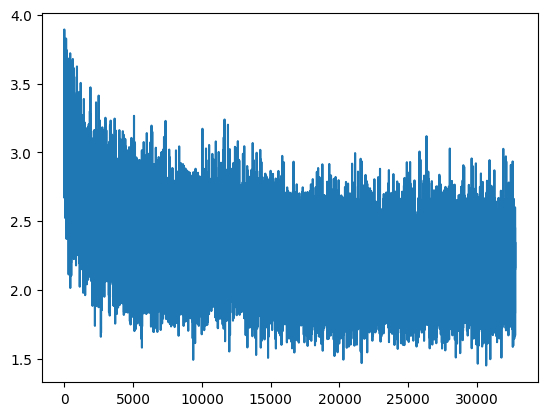

In [8]:
plt.plot(costs)

## Now let's see what the actor thinks would happen

In [9]:
rng, key = jax.random.split(key)
latent_start_state = encode_state(
    rng, start_state, train_state.target_net_state, train_state.train_config
)
expected_latent_states = jax.jit(infer_states)(rng, latent_start_state, optimized_actions, train_state.target_net_state, train_state.train_config)

In [10]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, expected_latent_states.shape[0])
expected_states = jax.jit(
    jax.vmap(
        Partial(
            decode_state,
            net_state=train_state.target_net_state,
            train_config=train_state.train_config,
        )
    )
)(rngs, expected_latent_states)

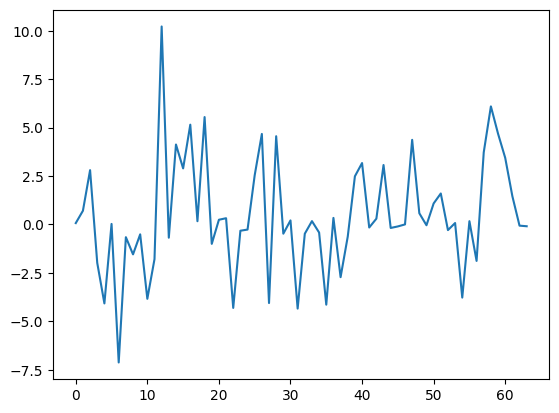

In [11]:
plt.plot(expected_states[..., 3])

In [12]:
import mediapy as media

media.show_video(
    env_cls.host_make_video(
        expected_states, train_state.train_config.env_config, dense=False
    ).transpose(0, 2, 3, 1)
)

: 

## Roll out the policy in the environment

In [22]:
def scanf(carry, key):
    """Scans to collect a single rollout of physics data."""
    state, i, policy_carry = carry

    rng, key = jax.random.split(key)
    action, policy_carry, policy_info = policy(
        key=rng,
        state=state,
        i=i,
        carry=policy_carry,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
    action = jnp.clip(
        action,
        a_min=train_config.env_config.action_bounds[..., 0],
        a_max=train_config.env_config.action_bounds[..., -1],
    )
    next_state, dense_states = train_config.env_cls.step(
        state, action, train_config.env_config
    )

    return (next_state, i + 1, policy_carry), (
        (state, action),
        dense_states,
        policy_info,
    )

rng, key = jax.random.split(key)
scan_rngs = jax.random.split(rng, train_config.rollout_length - 1)
_, ((states, actions), dense_states, policy_info) = jax.lax.scan(
    scanf,
    (start_state, 0, (optimized_actions, aux)),
    scan_rngs,
)

dense_states = rearrange(dense_states, "t u s -> (t u) s")

dense_states = jnp.concatenate([start_state[None], dense_states])
states = jnp.concatenate([states, start_state[None]])

In [7]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, eval_count)

start_state = env_cls.init()

(
    result_states,
    result_actions,
    result_infos,
    result_dense_states,
) = eval_batch_actor(
    rng,
    start_state,
    net_state=train_state.target_net_state,
    train_config=train_state.train_config,
    eval_count=eval_count,
    target_q=1.0,
)

In [8]:
result_states.shape

(32, 64, 6)

In [12]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, dense_states.shape[0])
latent_states = jax.vmap(
    Partial(
        encode_state,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    ),
)(key=rngs, state=dense_states)

In [56]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, dense_states.shape[0])
latent_actions = jax.vmap(
    Partial(
        encode_action,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
)(key=rngs, action=result_actions[0], latent_state=latent_states[:-1])

In [58]:
rng, key = jax.random.split(key)
inferred_latent_states = infer_states(
    key=rng,
    latent_start_state=latent_states[16],
    latent_actions=latent_actions,
    net_state=train_state.target_net_state,
    train_config=train_state.train_config,
    current_action_i=16,
)

In [59]:
diffs = inferred_latent_states[16:] - latent_states[17:]
diff_norms = jnp.linalg.norm(diffs, ord=1, axis=-1)

In [60]:
print(jnp.mean(diff_norms))

0.04850015


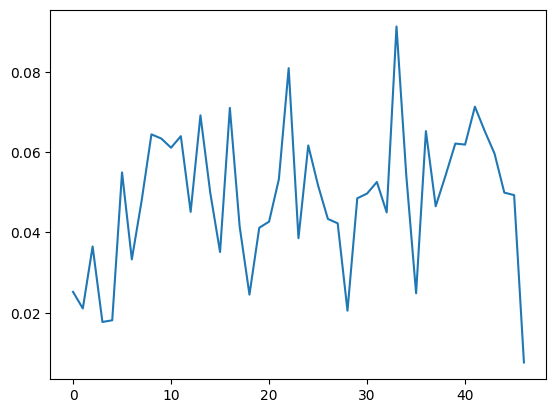

In [61]:
plt.plot(diff_norms)

## Let's make a scatterplot of all of the latent states and actions the algorithm decided on

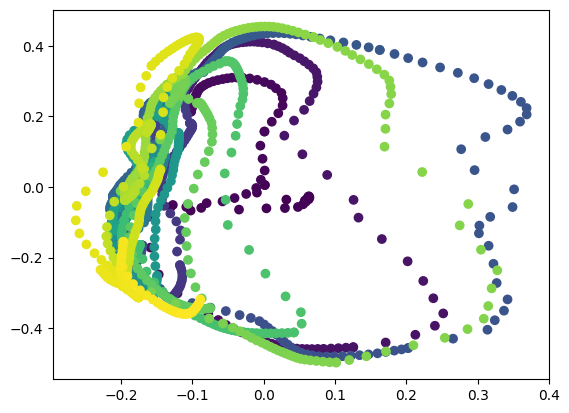

In [13]:
import numpy as np

plt.scatter(
    latent_states[..., 4],
    latent_states[..., 5],
    c=range(latent_states.shape[0]),
    cmap="viridis",
)

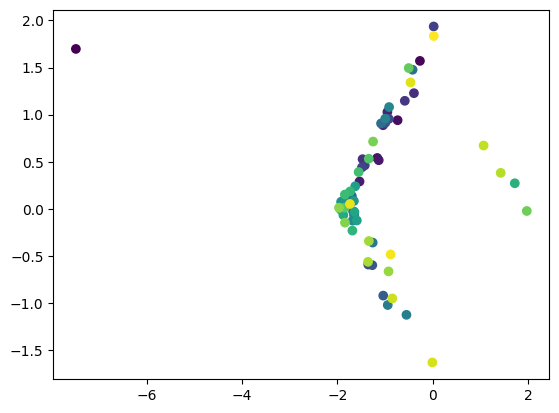

In [50]:
plt.scatter(optimized_actions[1, :, 0], optimized_actions[1, :, 1], c=range(len(optimized_actions[0])), cmap="viridis")

In [51]:
info.plain_infos['final_cost']

Array([0.44300872, 1.5922757 , 0.40527782, 0.8640153 , 0.93631995,
       1.3264173 , 1.8021476 , 1.1981711 , 2.8905616 , 2.4888887 ,
       1.5658545 , 1.359473  , 1.3002931 , 1.0043893 , 1.2830558 ,
       1.3513703 , 2.2248573 , 1.5408611 , 1.3750279 , 0.59131885,
       1.7496204 , 0.7838311 , 1.1012778 , 2.3042693 , 0.66868424,
       0.87299496, 0.615569  , 1.5800867 , 0.88201857, 0.6819191 ,
       0.9261382 , 0.35639948], dtype=float32)

## Let's plot the achieved final costs

(array([4., 4., 7., 6., 5., 2., 0., 2., 1., 1.]),
 array([0.35639948, 0.60981572, 0.8632319 , 1.11664808, 1.37006426,
        1.62348056, 1.87689674, 2.13031292, 2.38372922, 2.63714528,
        2.89056158]),
 <BarContainer object of 10 artists>)

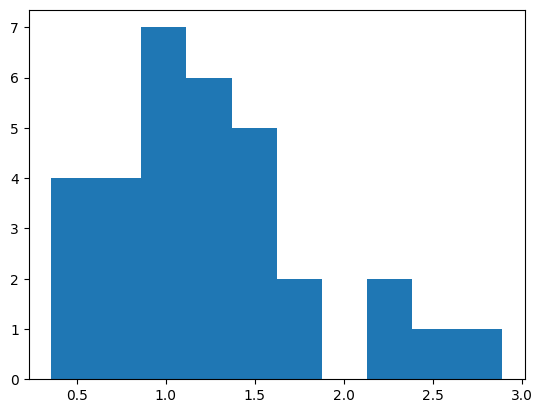

In [52]:
plt.hist(info.plain_infos['final_cost'])

## Let's visualize what the algorithm did

In [16]:
import mediapy as media

video = env_cls.host_make_video(dense_states, env_config).transpose(0, 2, 3, 1)
media.show_video(video, fps=24)

## Let's visualize what the algorithm thought would happen

In [54]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, predicted_latent_states.shape[1])
predicted_states = jax.vmap(
    jax.tree_util.Partial(decode_state, vibe_state=vibe_state, vibe_config=vibe_config)
)(rngs, predicted_latent_states[1])

In [55]:
video = env_cls.host_make_video(predicted_states, env_config).transpose(0, 2, 3, 1)
media.show_video(video, fps=24)

## Let's investigate what action space actions are available from the start state

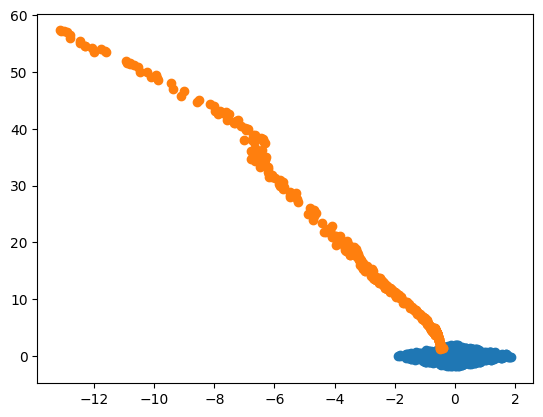

In [13]:
sample_count = 512
rng, key = jax.random.split(key)
action_samples = (
    jax.random.ball(rng, d=train_state.train_config.latent_action_dim, p=1, shape=[sample_count])
    * train_state.train_config.action_radius
)

rng, key = jax.random.split(key)
rngs = jax.random.split(rng, sample_count)
action_space_actions = jax.vmap(
    jax.tree_util.Partial(
        decode_action,
        latent_state=latent_states[0],
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
)(rngs, action_samples)

plt.scatter(x=action_samples[..., 0], y=action_samples[..., 1])
plt.scatter(x=action_space_actions[..., 0], y=action_space_actions[..., 1])

# set lims
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

In [57]:
vibe_config.env_config.action_bounds.T

Array([[-0.5, -0.5],
       [ 0.5,  1.5]], dtype=float32)